# Grubb's Test for Outlier Detection

**H0**: There are no outliers in the data set <br>
**H1**: There is exactly one outlier in the data set 
<br>
The Grubbs' test statistic is defined as: 
$$G = \frac{\text{max} \left| X_i - \bar{X} \right|}{s},$$ 

where $X_i$ is an individual data point in the dataset, and $\bar{X}$ and $s$ denote the sample mean and standard deviation, respectively. The term $\text{max} \left| X_i - \bar{X} \right|$ is the maximum absolute deviation from the mean. 

The Grubbs' test statistic is the largest absolute deviation from the sample mean in units of the sample standard deviation. 

The critical value of the Grubb's test statistic can be calculated as folows: 

$$G_{critical}=\frac{(N-1)}{\sqrt{N}} \sqrt{\frac{\left(t_{\alpha /(2 N), N-2}\right)^{2}}{N-2+\left(t_{\alpha /(2 N), N-2}\right)^{2}}}$$


In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

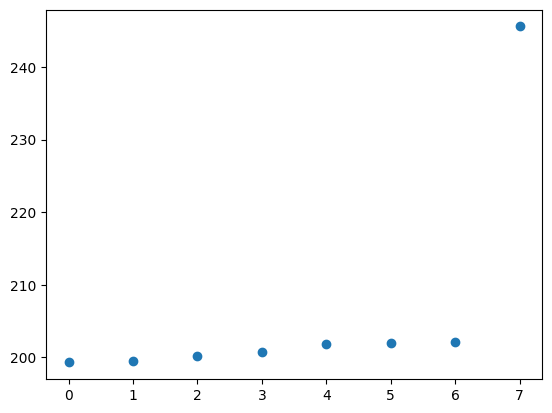

In [3]:
# Define sample data including a single outlier
y = np.array([199.31, 199.53, 200.19, 200.82, 201.92, 201.95, 202.18, 245.57])
x = np.arange(len(y))
plt.scatter(x,y)
plt.show

In [62]:
def grubbs_critical_value(size, alpha=0.05,quiet=True):
    """Calculate the critical value with the formula given for example in
    https://en.wikipedia.org/wiki/Grubbs%27_test_for_outliers#Definition
    Args:
        ts (list or np.array): The timeseries to compute the critical value.
        alpha (float): The significance level (5% by default).
    Returns:
        float: The critical value for this test.
    """
    t_dist = stats.t.ppf(1 - alpha / (2 * size), size - 2)
    numerator = (size - 1) * np.sqrt(np.square(t_dist))
    denominator = np.sqrt(size) * np.sqrt(size - 2 + np.square(t_dist))
    critical_value = numerator / denominator
    if quiet:
        pass
    else:
        print(f'Grubbs critical value: \t\t\t {critical_value:10.8f}')
    return critical_value

In [63]:
def grubbs_stat(X, alpha=0.05):
    m = np.mean(X) # mean (i.e., average) of the data
    s = np.std(X)  # st.dev of the data
    abs_val_minus_avg = abs(X - m)
    max_of_deviations = max(abs_val_minus_avg)
    max_ind = np.argmax(abs_val_minus_avg) # save the index of that maximum valued observation
    
    Gstats = max_of_deviations/ s
    critical_value=grubbs_critical_value(len(X),alpha)
    print(f'Grubbs calculated test statistic: \t{Gstats:10.8f}')
    if Gstats>critical_value:
        print('Reject the null hypothesis. There appears to be outlier(s).')
    else:
        print('Failed to reject the null hypothesis. There appears to be no outlier(s).')
    return Gstats, max_ind

In [64]:
Grubbs_critical_value(len(y))

Grubbs critical value: 			 3.38408290


3.384082902288351

In [65]:
grubbs_stat(y,alpha=0.01)

Grubbs calculated test statistic: 	7.22420074
Reject the null hypothesis. There appears to be outlier(s).


(7.224200741076346, 50)

# The Generalized Extreme Studentized Deviate (ESD) Test 

The Generalized Extreme Studentized Deviate (ESD) Test is a generalization of Grubbs’ Test and handles more than one outlier. All you need to do is provide an upper bound on the number of potential outliers.

We test the null hypothesis that the data has no outliers vs. the alternative hypothesis that there are at most k outliers (for some user-specified value of k).

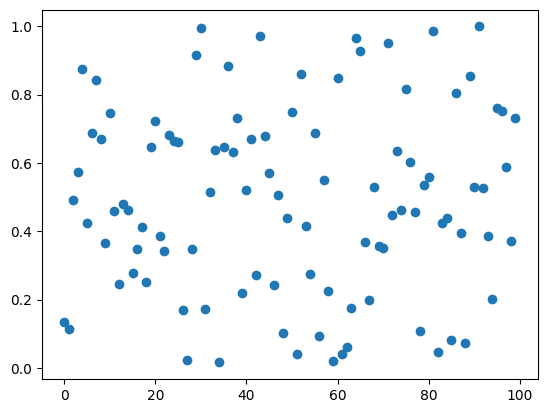

In [99]:
# Generate some data
y = np.random.random(100)
x = np.arange(len(y))
plt.scatter(x,y)

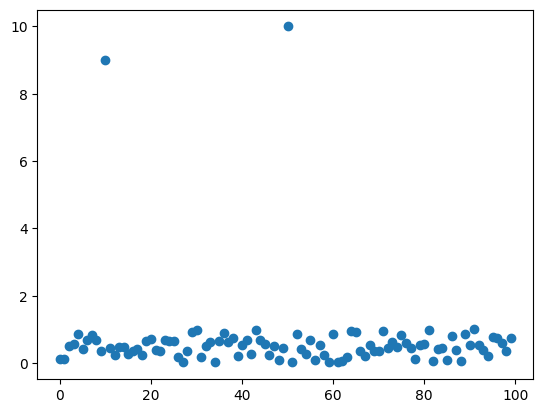

In [100]:
# Impute outliers
y[10] = 9
y[50] = 10
plt.scatter(x,y)

In [101]:
grubbs_stat(y,alpha=0.01)

Grubbs calculated test statistic: 	7.22282267
Reject the null hypothesis. There appears to be outlier(s).


(7.2228226677970255, 50)

In [102]:
def check_G_values(Gs, Gc, inp, max_index):
    if Gs > Gc:
        print('{} at index {} is an outlier. G > G-critical: {:.4f} > {:.4f} \n'.format(inp[max_index],max_index, Gs, Gc))
        return True
    else:
        print('{} at index {} is not an outlier. G <= G-critical: {:.4f} <= {:.4f} \n'.format(inp[max_index],max_index, Gs, Gc))
        return False

In [103]:
def ESD_Test(input_series, alpha, max_outliers, plot=True):
    original_series = np.array(input_series)  # Keep the original series for plotting
    outlier_indices = []
    tested_indices = []
    deleted_indices = []  # Keep track of deleted indices
    
    for iterations in range(max_outliers):
        Gcritical = grubbs_critical_value(len(input_series), alpha)
        Gstat, max_index = grubbs_stat(input_series)
        actual_index = max_index + sum(i < max_index for i in deleted_indices)  # Adjust index based on deletions
        if check_G_values(Gstat, Gcritical, input_series, max_index):
            outlier_indices.append(actual_index)
        else:
            tested_indices.append(actual_index)
        input_series = np.delete(input_series, max_index)
        deleted_indices.append(actual_index)  # Add the actual index to the list of deleted indices

    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(original_series, 'bo', label='Normal Observations', alpha=0.5)
        if outlier_indices:
            plt.plot(outlier_indices, original_series[outlier_indices], 'ro', label='Tested Outliers')
        if tested_indices:
            plt.plot(tested_indices, original_series[tested_indices], 'go', label='Tested but Not Outliers')
        plt.legend()
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.title('ESD Test Results')
        plt.show()

    return outlier_indices, tested_indices

Grubbs calculated test statistic: 	7.22282267
Reject the null hypothesis. There appears to be outlier(s).
10.0 at index 50 is an outlier. G > G-critical: 7.2228 > 3.3841 

Grubbs calculated test statistic: 	9.43512964
Reject the null hypothesis. There appears to be outlier(s).
9.0 at index 10 is an outlier. G > G-critical: 9.4351 > 3.3807 

Grubbs calculated test statistic: 	1.88968754
Failed to reject the null hypothesis. There appears to be no outlier(s).
0.9991871860250487 at index 89 is not an outlier. G <= G-critical: 1.8897 <= 3.3772 

Grubbs calculated test statistic: 	1.91846487
Failed to reject the null hypothesis. There appears to be no outlier(s).
0.9946576347809076 at index 29 is not an outlier. G <= G-critical: 1.9185 <= 3.3737 

Grubbs calculated test statistic: 	1.93252227
Failed to reject the null hypothesis. There appears to be no outlier(s).
0.9856798800288699 at index 78 is not an outlier. G <= G-critical: 1.9325 <= 3.3701 



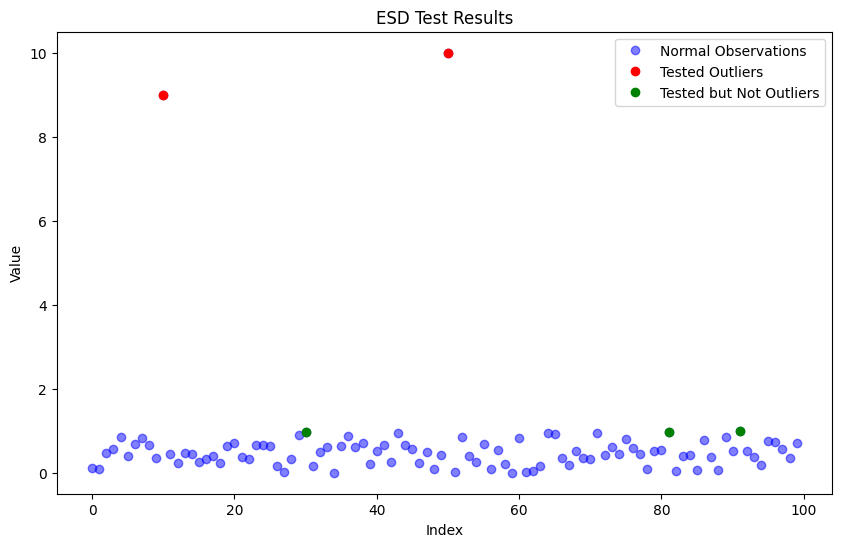

([50, 10], [91, 30, 81])

In [106]:
ESD_Test(y, alpha=0.05, max_outliers=5, plot=True)